In [1]:
import sys,os,copy,glob,time
import numpy as np
sys.path.append(os.path.abspath('../../smodels'))
from smodels.tools.physicsUnits import fb
from smodels.tools import runtime
from smodels.tools import statistics
from smodels.tools.simplifiedLikelihoods import UpperLimitComputer, Data, LikelihoodComputer
runtime._experimental = True
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats,integrate,optimize,special
import matplotlib.font_manager

from smodels.experiment.databaseObj import Database
from tqdm.notebook import tqdm
from multiprocessing import Pool
import warnings
import shutil
import pickle

runtime._cap_likelihoods = False
runtime._drmax=100000.
sns.set_style('ticks',{'font.family':'Times New Roman', 'font.serif':'Times New Roman'})
sns.set_context('paper', font_scale=2.0)
sns.set_palette(sns.color_palette("Paired"))


In [2]:
def getSRs():
    from smodels.experiment.databaseObj import Database
    db = Database ( "official" )
    ers = db.getExpResults( dataTypes=[ "efficiencyMap" ] )
    stats_ = []
    for er in ers:
        for ds in er.datasets:
            D = { "obsN": ds.dataInfo.observedN, "expectedBG": ds.dataInfo.expectedBG,
                  "bgError": ds.dataInfo.bgError, "upperLimit": ds.dataInfo.upperLimit,
                  "expectedUpperLimit": ds.dataInfo.expectedUpperLimit }
            stats_.append ( D )
    return stats_

In [3]:
stats_ = getSRs()

In [4]:
def getNorm(func, args, b, getMulim=False):
    err = 1.
    ctr = 0
    b = 2*b
    norm = integrate.quad(func, 0 , b, args, epsabs=0.,epsrel=1e-3)[0]
    while err > 0.01:
        ctr+=1
        if ctr > 50.:
            raise Exception("Could not compute norm within required precision")
        norm_old = norm
        b = b*1.2
        norm = integrate.quad(func, 0, b, args, epsabs=0., epsrel=1e-3)[0]
        if norm == 0.:
            continue
        err = abs(norm_old-norm)/norm
    if getMulim:
        return norm, b
    return norm

In [7]:
mod_factors = [0, 0.25, 0.5, 0.6, 0.75, 1, 2]

In [10]:
# ### Compute observed and expected upper limits
def run ( nobs, nExp, nExpErr, nsig, plotname=False):
    """ run the procedure, with:
    :param nobs: number of observed
    :param nExp: number expected
    :param nExpErr: error on number expected
    """
    print ( "Starting run with nobs", nobs, "nExp", nExp )
    data = Data ( nobs, nExp, nExpErr**2, nsignal = nsig)
    computer = UpperLimitComputer ( 10000 )
    marginalize = False #True
    ULobs = computer.ulSigma ( data, marginalize=marginalize )

    ULexp = computer.ulSigma ( data, expected=True, marginalize=marginalize )
    
    print(r'Nobs = %1.2f, Nbg = %1.2f +- %1.2f, Nsig < %1.2f, Nsig (expected) < %1.2f'
         %(nobs,nExp,nExpErr,ULobs,ULexp))

    nsteps = 100 # 100
    
    mulim = abs(nobs-nExp+4*nExpErr)
    Lmax = 1
    while Lmax > .01:
        Lmax = statistics.likelihoodFromLimits(ULobs, ULexp, mulim, underfluct="norm_0")
        mulim = 1.2 * mulim
    muvals = np.linspace(0, mulim, nsteps )
    
    smllhd = LikelihoodComputer(data)
    
    norm_gauss = getNorm(smllhd.marginalizedLLHD1D, args=(False), b=max(ULobs,ULexp))
    norm_loggauss = getNorm(smllhd.marginalizedLLHD1D, args=(False, "lognormal"), b=max(ULobs,ULexp))
    norm_profiled = getNorm(smllhd.profileLikelihood, args=(False), b=max(ULobs,ULexp))
    
    
    llhds_full_norm = np.array([[mu, smllhd.marginalizedLLHD1D(mu, nll=False)/norm_gauss] for mu in muvals])
    llhds_full_profiled = np.array([[mu, smllhd.profileLikelihood(mu, nll=False)/norm_profiled] for mu in muvals])
    
    f = plt.figure(figsize=(20,10))
    
    plt.plot(llhds_full_norm[:,0],llhds_full_norm[:,1],label='Poisson marg. with Normal Error',linewidth=3, color="g")
    plt.plot(llhds_full_profiled[:,0],llhds_full_profiled[:,1],label='Profile Likelihood',linewidth=3, color="m")
    
    
    colors=["lightsteelblue", "slategrey", "royalblue", "blue", "navy", "black", "magenta"]
    i=0
    for mf in mod_factors:
        ULexp_mod = ULexp / (1. - mf*((ULobs-ULexp)/(ULobs+ULexp)))
        llhds_app_mod = np.array([[mu, statistics.likelihoodFromLimits(ULobs, ULexp_mod, mu, underfluct="norm_neg")] for mu in muvals])
        plt.plot(llhds_app_mod[:,0],llhds_app_mod[:,1],label='Normal, modified $\sigma$, x={}'.format(mf), linestyle="--", linewidth=3, color=colors[i])
        i+=1    
            
    plt.legend()
    plt.xlabel(r'$\mu$')
    plt.ylabel(r'$L$')
    plt.title(r'$N_{obs} = %1.2f, N_{bg} = %1.2f \pm %1.2f, \sigma_{UL}^{obs} = %1.2f, \sigma_{UL}^{exp} = %1.2f, \Delta = %1.2f$'
              %(nobs,nExp,nExpErr,ULobs,ULexp,abs(ULobs-ULexp)/(ULobs+ULexp)),fontsize=14)
    if not plotname:
        plt.show()
        return
    
    plt.savefig("./plots_mod/"+str(plotname))
    plt.close()
    


Starting run with nobs 6 nExp 4.1
Nobs = 6.00, Nbg = 4.10 +- 1.90, Nsig < 8.52, Nsig (expected) < 6.18


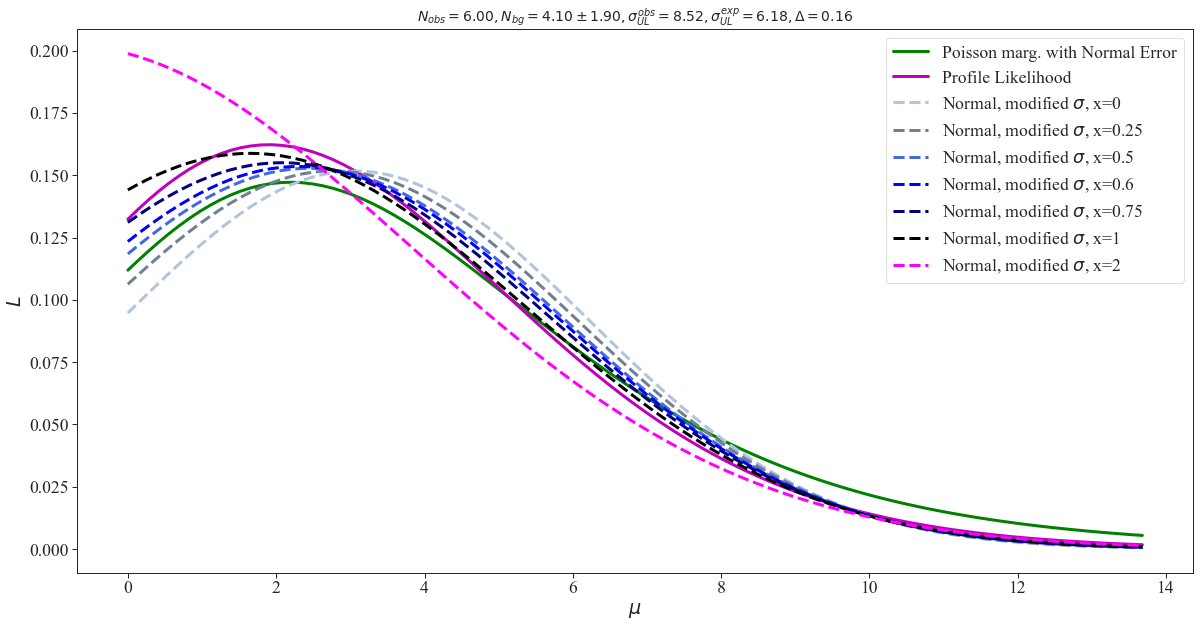

In [11]:
j = 71
run(int(stats_[j]["obsN"]), stats_[j]["expectedBG"], stats_[j]["bgError"], 1)

In [12]:
def num_moments(funct, mulim=np.inf):
    integrand_ev = lambda mu: mu*funct(mu)
    ev = integrate.quad(integrand_ev, 0., mulim, epsabs=0.,epsrel=1e-3)[0]
    
    integrand_var = lambda mu: (mu**2)*funct(mu)
    ev_x2 = integrate.quad(integrand_var, 0, mulim,epsabs=0.,epsrel=1e-3)[0]
    var = ev_x2 - ev**2
    
    integrand_skew = lambda mu: (mu**3)*funct(mu)
    ev_x3 = integrate.quad(integrand_skew, 0, mulim, epsabs=0.,epsrel=1e-3)[0]
    skew = ( ev_x3 - 3*ev*var - ev**3 ) / (var**(3/2))
    
    negllhd = lambda mu: -funct(mu)
    res = optimize.minimize(fun=negllhd, x0=ev, method="TNC", bounds=[(0.,np.inf)])
    if res["x"]<1e-5:
        mod = 0
    else:    
        mod = float(res["x"])
    
    return ({"ev":ev, "var":var, "skew":skew, "mode":mod})

In [13]:
# ### Compute observed and expected upper limits
def compare_methods ( nobs, nExp, nExpErr, nsig, mod_factor ):
    """ Compare Moments and mean of different Methods for calculating likelihoods out of given Data:
    :param nobs: number of observed
    :param nExp: number expected
    :param nExpErr: error on number expected
    """
    data = Data ( nobs, nExp, nExpErr**2, nsignal = nsig)
    computer = UpperLimitComputer ( 10000 )
    marginalize = False #True
    ULobs = computer.ulSigma ( data, marginalize=marginalize )

    ULexp = computer.ulSigma ( data, expected=True, marginalize=marginalize )
    ULexp_mod = ULexp / (1. - mod_factor*((ULobs-ULexp)/(ULobs+ULexp)))
    
    smllhd = LikelihoodComputer(data)
    
    res = {}
    
    modes_full = ["normal"]
    for mode in modes_full:
        norm, mulim = getNorm(smllhd.marginalizedLLHD1D, args=(False, mode), b=max(ULobs,ULexp), getMulim=True)
        llhd_full = lambda mu: smllhd.marginalizedLLHD1D(mu, nll=False, bg_error=mode)/norm
        res[mode] = num_moments(llhd_full, mulim)
    
    norm_profiled, mulim_profiled = getNorm(smllhd.profileLikelihood, args=(False), b=max(ULobs,ULexp), getMulim=True)
    llhd_profiled = lambda mu: smllhd.profileLikelihood(mu, nll=False)/norm_profiled
    res["profiled"] = num_moments(llhd_profiled, mulim_profiled)
    
    #modes_app = ["norm_0", "norm_neg", "exp"]
    #modes_app = ["norm_0", "norm_neg"]
    modes_app = ["norm_neg"]
    for mode in modes_app:
        res[mode] = statistics.llhdFromLimits_moments(ULobs, ULexp, underfluct=mode)
    res["mod"] = statistics.llhdFromLimits_moments(ULobs, ULexp_mod, underfluct="norm_neg")
    
    return res   

In [14]:
def make_llhds_meta_m(mod_factors):
    llhds_meta_m = {}
    for mf in mod_factors:
        print("Working on mod_factor {}".format(mf))
        llhds_meta_m[mf] = []
        for i in tqdm(range(len(stats_))):
            llhds_meta_m[mf].append(compare_methods(int(stats_[i]["obsN"]), stats_[i]["expectedBG"], stats_[i]["bgError"], 1, mf))

    with open('meta_mod/llhds_meta_mod.pkl', 'wb') as f:
            pickle.dump(llhds_meta_m, f)

    return llhds_meta_m

In [15]:
if not os.path.exists("meta_mod"):
    os.mkdir("meta_mod")
    llhds_meta_m = make_llhds_meta_m(mod_factors)
else:
    new_plot = input('Would you like to redo the meta analysis? (y/n)\n')
    if new_plot.lower() == 'yes' or new_plot.lower() == 'y':
        shutil.rmtree("meta_mod")
        os.mkdir("meta_mod")
        llhds_meta_m = make_llhds_meta_m(mod_factors)
    else:
        print("Reading...")
        with open("meta/llhds_meta_mod.pkl", "rb") as f:
            llhds_meta_m = pickle.load(f)
        print("Done.")

Would you like to redo the meta analysis? (y/n)
y
Working on mod_factor 0


  0%|          | 0/271 [00:00<?, ?it/s]

Working on mod_factor 0.25


  0%|          | 0/271 [00:00<?, ?it/s]

Working on mod_factor 0.5


  0%|          | 0/271 [00:00<?, ?it/s]

Working on mod_factor 0.6


  0%|          | 0/271 [00:00<?, ?it/s]

Working on mod_factor 0.75


  0%|          | 0/271 [00:00<?, ?it/s]

Working on mod_factor 1


  0%|          | 0/271 [00:00<?, ?it/s]

Working on mod_factor 2


  0%|          | 0/271 [00:00<?, ?it/s]

# Analyze Metadata

In [16]:
def reldiff(ex, app):
    if(ex < 0 or app < 0): return(warnings.warn("Negative Value encountered"))
    if(ex+app == 0): return(0)
    return(2*(ex-app) / (app+ex))

In [44]:
modes_full = ["normal", "profiled"]
modes_app = ["norm_neg", "mod"]
moments = ["ev", "var", "skew", "mode"]
reldiffs = {}
for mf in mod_factors:
    reldiffs[mf] = []
    for i in range(len(llhds_meta_m[mf])):
        tempdict = {}
        for mode_f in modes_full:
            for mode_a in modes_app:
                for moment in moments:
                    try:
                        ex = llhds_meta_m[mf][i][mode_f][moment]
                        app = llhds_meta_m[mf][i][mode_a][moment]
                        tempdict[mode_f+"_vs_"+mode_a+"_"+moment] = reldiff(ex, app)
                    except:
                        print(i, mode_f, mode_a, moment)
        reldiffs[mf].append(tempdict)


In [19]:
###Means of relative Differences
means = {}
for mf in mod_factors:
    means[mf] = {}
    for moment in moments:
        for mode_f in modes_full:
            for mode_a in modes_app:
                mean = np.mean([reldiffs[mf][x][mode_f+"_vs_"+mode_a+"_"+moment] for x in range(len(reldiffs))])
                means[mf][mode_f+"_vs_"+mode_a+"_"+moment] = mean
            

In [20]:
list_lower = [stats_[x]["obsN"] < stats_[x]["expectedBG"] for x in range(len(stats_))]
list_greater = [stats_[x]["obsN"] >= stats_[x]["expectedBG"] for x in range(len(stats_))]
lower = np.where(list_lower)[0]
greater = np.where(list_greater)[0]

In [21]:
def find_range(mode_f):
    range_={}
    for moment in moments:
        ma = -1e2
        mi = 1e2
        for mode_a in modes_app:
            for mf in mod_factors:
                ma_temp = max([reldiffs[mf][x][mode_f+"_vs_"+mode_a+"_"+moment] for x in range(len(llhds_meta_m[mf]))])
                mi_temp = min([reldiffs[mf][x][mode_f+"_vs_"+mode_a+"_"+moment] for x in range(len(llhds_meta_m[mf]))])
                if ma < ma_temp: ma = ma_temp
                if mi > mi_temp: mi = mi_temp
        range_[moment]=(mi,ma)
    return(range_)

In [22]:
#names = {"ev":"Expected Value", "var":"Variance", "skew":"Skewness", "mode":"Mode",\
#        "normal":"Poisson marginalized with Normal Error", "lognormal":"Poisson marginalized with Lognormal Error", "profiled":"Profile Likelihood",\
#        "norm_0":"Truncated Normal loc >= 0", "norm_neg":"Truncated Normal","exp":"Truncated Normal, Exponential when Underfluctuation"}

names = {"ev":"Expected Value", "var":"Variance", "skew":"Skewness", "mode":"Mode",\
        "normal":"Poisson marginalized with Normal Error", "lognormal":"Poisson marginalized with Lognormal Error", "profiled":"Profile Likelihood",\
        "norm_0":"Truncated Normal loc >= 0", "norm_neg":"Truncated Normal","mod":"Truncated Normal with modified sigma"}

In [23]:
def makehists():
    bins_=15
    
    #single Hists
    #for mode_f in modes_full:
    #    for mode_a in modes_app:
    #        for moment in moments:
    #            plt.figure(figsize=(10,8))
    #            obsNlower = [reldiffs[x][mode_f+"_vs_"+mode_a+"_"+moment] for x in lower]  
    #            obsNgreater = [reldiffs[x][mode_f+"_vs_"+mode_a+"_"+moment] for x in greater]
    #            hist_ = plt.hist([obsNgreater, obsNlower], bins=bins_, stacked=True, label=["ObsN>ExpBG","ObsN<=ExpBG"])
    #            plt.legend()
    #            minr = min(hist_[1])
    #            maxn = max(hist_[0][1])
    #            plt.text(minr, maxn/10, "$\mu$ = {:.2f}".format(means[mode_f+"_vs_"+mode_a+"_"+moment]))
    #            plt.savefig("./hists/"+mode_f+"_vs_"+mode_a+"_"+moment)
    #            plt.close()
    
        
    #grouped stacked Hists    
    for mode_f in modes_full:
        nx = len(mod_factors)
        ny = len(moments)
        fig, ax = plt.subplots(ny, nx, figsize=(32,15), constrained_layout=True)
        fig.suptitle(names[mode_f]+" vs modified truncated Gaussian")
        j = 0
        ranges = find_range(mode_f)
        for mf in mod_factors:
            i = 0
            for moment in moments:
                mode_a = "mod"
                if i == 0:
                    ax[i,j].set_title("modified with x="+str(mf)+"\n\n"+names[moment])
                else:
                    ax[i,j].set_title(names[moment])
                obsNlower = [reldiffs[mf][x][mode_f+"_vs_"+mode_a+"_"+moment] for x in lower]  
                obsNgreater = [reldiffs[mf][x][mode_f+"_vs_"+mode_a+"_"+moment] for x in greater]
                hist_ = ax[i,j].hist([obsNgreater, obsNlower], bins=bins_, stacked=True, range=ranges[moment], label=["ObsN>ExpBG","ObsN<=ExpBG"])
                ax[i,j].legend()
                maxn = max(hist_[0][1])
                ax[i,j].text(ranges[moment][0], maxn/10, "$\mu$ = {:.2f}".format(means[mf][mode_f+"_vs_"+mode_a+"_"+moment]))
                i += 1
            j += 1

        plt.savefig("./hists_mod/"+mode_f+"_stacked"+"mf.png")
        plt.close()
        plt.show()

In [24]:
if not os.path.exists("hists_mod"):
    os.mkdir("hists_mod")
    makehists()
else:
    new_plot = input('Would you like to redo the hists? (y/n)\n')
    if new_plot.lower() == 'yes' or new_plot.lower() == 'y':
        shutil.rmtree("hists_mod")
        os.mkdir("hists_mod")
        makehists()
    else:
        print("Aborting")

Would you like to redo the hists? (y/n)
y


In [25]:
if not os.path.exists("plots_mod"):
    os.mkdir("plots_mod")
    for i in tqdm(range(len(stats_))):
            run(int(stats_[i]["obsN"]), stats_[i]["expectedBG"], stats_[i]["bgError"], 1, plotname="llhds"+str(i)+".png")
else:
    new_plot = input('Would you like to redo the Plots? (y/n)\n')
    if new_plot.lower() == 'yes' or new_plot.lower() == 'y':
        shutil.rmtree("plots_mod")
        os.mkdir("plots_mod")
        for i in tqdm(range(len(stats_))):
            run(int(stats_[i]["obsN"]), stats_[i]["expectedBG"], stats_[i]["bgError"], 1, plotname="llhds"+str(i)+".png")
    else:
        print("Aborting")

Would you like to redo the Plots? (y/n)
y


  0%|          | 0/271 [00:00<?, ?it/s]

Starting run with nobs 12 nExp 5.5
Nobs = 12.00, Nbg = 5.50 +- 0.72, Nsig < 13.32, Nsig (expected) < 6.79
Starting run with nobs 1 nExp 1.25
Nobs = 1.00, Nbg = 1.25 +- 0.26, Nsig < 3.21, Nsig (expected) < 3.21
Starting run with nobs 1 nExp 1.03
Nobs = 1.00, Nbg = 1.03 +- 0.18, Nsig < 3.39, Nsig (expected) < 3.39
Starting run with nobs 263 nExp 283
Nobs = 263.00, Nbg = 283.00 +- 24.00, Nsig < 42.10, Nsig (expected) < 57.87
Starting run with nobs 191 nExp 191
Nobs = 191.00, Nbg = 191.00 +- 21.00, Nsig < 49.67, Nsig (expected) < 49.67
Starting run with nobs 26 nExp 23
Nobs = 26.00, Nbg = 23.00 +- 4.00, Nsig < 15.86, Nsig (expected) < 13.08
Starting run with nobs 7 nExp 4.1
Nobs = 7.00, Nbg = 4.10 +- 1.10, Nsig < 8.98, Nsig (expected) < 5.53
Starting run with nobs 7 nExp 13.2
Nobs = 7.00, Nbg = 13.20 +- 2.20, Nsig < 4.91, Nsig (expected) < 9.12
Starting run with nobs 4 nExp 6.9
Nobs = 4.00, Nbg = 6.90 +- 1.50, Nsig < 4.55, Nsig (expected) < 7.17
Starting run with nobs 3 nExp 4.2
Nobs = 3.0

Starting run with nobs 16 nExp 8.8
Nobs = 16.00, Nbg = 8.80 +- 2.80, Nsig < 16.49, Nsig (expected) < 9.06
Starting run with nobs 11 nExp 11.3
Nobs = 11.00, Nbg = 11.30 +- 3.10, Nsig < 9.41, Nsig (expected) < 9.41
Starting run with nobs 7 nExp 7.3
Nobs = 7.00, Nbg = 7.30 +- 1.50, Nsig < 6.78, Nsig (expected) < 6.78
Starting run with nobs 0 nExp 1.1
Nobs = 0.00, Nbg = 1.10 +- 1.10, Nsig < 3.15, Nsig (expected) < 3.77
Starting run with nobs 64 nExp 45.7
Nobs = 64.00, Nbg = 45.70 +- 5.95, Nsig < 35.99, Nsig (expected) < 18.76
Starting run with nobs 981 nExp 965.9
Nobs = 981.00, Nbg = 965.90 +- 85.28, Nsig < 192.63, Nsig (expected) < 178.16
Starting run with nobs 23 nExp 11.8
Nobs = 23.00, Nbg = 11.80 +- 2.41, Nsig < 20.98, Nsig (expected) < 9.45
Starting run with nobs 249 nExp 285.5
Nobs = 249.00, Nbg = 285.50 +- 27.08, Nsig < 37.16, Nsig (expected) < 63.44
Starting run with nobs 48 nExp 38.8
Nobs = 48.00, Nbg = 38.80 +- 6.54, Nsig < 27.03, Nsig (expected) < 18.59
Starting run with nobs 49

Starting run with nobs 2 nExp 1.0
Nobs = 2.00, Nbg = 1.00 +- 0.50, Nsig < 4.77, Nsig (expected) < 3.50
Starting run with nobs 3 nExp 3.2
Nobs = 3.00, Nbg = 3.20 +- 0.70, Nsig < 4.74, Nsig (expected) < 4.74
Starting run with nobs 21 nExp 23.3
Nobs = 21.00, Nbg = 23.30 +- 3.70, Nsig < 10.70, Nsig (expected) < 12.46
Starting run with nobs 33 nExp 38.2
Nobs = 33.00, Nbg = 38.20 +- 5.10, Nsig < 12.41, Nsig (expected) < 16.31
Starting run with nobs 5 nExp 3.3
Nobs = 5.00, Nbg = 3.30 +- 0.70, Nsig < 7.14, Nsig (expected) < 4.65
Starting run with nobs 217 nExp 236
Nobs = 217.00, Nbg = 236.00 +- 29.00, Nsig < 48.85, Nsig (expected) < 64.62
Starting run with nobs 12 nExp 13
Nobs = 12.00, Nbg = 13.00 +- 2.20, Nsig < 8.53, Nsig (expected) < 9.32
Starting run with nobs 11 nExp 15.8
Nobs = 11.00, Nbg = 15.80 +- 1.90, Nsig < 6.33, Nsig (expected) < 10.01
Starting run with nobs 4 nExp 4.1
Nobs = 4.00, Nbg = 4.10 +- 0.80, Nsig < 5.38, Nsig (expected) < 5.38
Starting run with nobs 5 nExp 4.1
Nobs = 5.00

Starting run with nobs 32 nExp 22.8
Nobs = 32.00, Nbg = 22.80 +- 5.20, Nsig < 23.48, Nsig (expected) < 14.73
Starting run with nobs 98 nExp 109
Nobs = 98.00, Nbg = 109.00 +- 18.00, Nsig < 31.88, Nsig (expected) < 41.12
Starting run with nobs 38 nExp 42.8
Nobs = 38.00, Nbg = 42.80 +- 9.50, Nsig < 18.64, Nsig (expected) < 23.27
Starting run with nobs 23 nExp 17.6
Nobs = 23.00, Nbg = 17.60 +- 4.10, Nsig < 17.57, Nsig (expected) < 12.72
Starting run with nobs 94 nExp 86
Nobs = 94.00, Nbg = 86.00 +- 17.00, Nsig < 46.00, Nsig (expected) < 38.26
Starting run with nobs 39 nExp 29.7
Nobs = 39.00, Nbg = 29.70 +- 5.80, Nsig < 25.20, Nsig (expected) < 16.61
Starting run with nobs 6159 nExp 6088
Nobs = 6159.00, Nbg = 6088.00 +- 665.00, Nsig < 1383.21, Nsig (expected) < 1312.36
Starting run with nobs 2305 nExp 2278
Nobs = 2305.00, Nbg = 2278.00 +- 266.00, Nsig < 556.51, Nsig (expected) < 529.73
Starting run with nobs 454 nExp 418
Nobs = 454.00, Nbg = 418.00 +- 66.00, Nsig < 171.06, Nsig (expected) <

In [30]:
ylabels = {"ev":r"$2*\frac{ev_{full}-ev_{app}}{ev_{full}+ev_{app}}$",\
          "var":r"$2*\frac{Var_{full}-Var_{app}}{Var_{full}+Var_{app}}$",\
          "skew":r"$2*\frac{skew_{full}-skew_{app}}{skew_{full}+skew_{app}}$",\
          "mode":r"$2*\frac{mode_{full}-mode_{app}}{mode_{full}+mode_{app}}$"}

In [28]:
ULobs, ULexp = [],[]
for i in range(len(stats_)):
    data = Data(stats_[i]["obsN"], stats_[i]["expectedBG"], stats_[i]["bgError"]**2, nsignal=1)
    computer = UpperLimitComputer ( 10000 )
    marginalize = False #True
    ULobs.append(computer.ulSigma ( data, marginalize=marginalize ))
    ULexp.append(computer.ulSigma ( data, expected=True, marginalize=marginalize ))


ULdiffs = []

for i in range(len(stats_)):
    ULdiffs.append(reldiff(ULobs[i], ULexp[i]))
 

In [37]:
def makescatterplots():
    for mode in modes_full:
        for moment in moments:
            fig, ax = plt.subplots(figsize=(20,10))
            for mf in mod_factors:
                reldiffs_moment = [reldiffs[mf][x][mode+"_vs_"+"mod"+"_"+moment] for x in range(len(stats_))]
                ax.scatter(ULdiffs, reldiffs_moment, label="x = {}".format(mf))
            plt.xlabel(r"$2*\frac{UL_{exp}-UL_{obs}}{UL_{exp}+UL_{obs}}$")
            plt.ylabel(ylabels[moment])
            ax.grid(True)
            plt.title(names[mode]+" vs modified truncated Gaussian")
            ax.legend()
            plt.savefig("./scatter_mod/"+str(mode+moment))
            plt.show()
            plt.close()

Would you like to redo the scatterplots? (y/n)
y


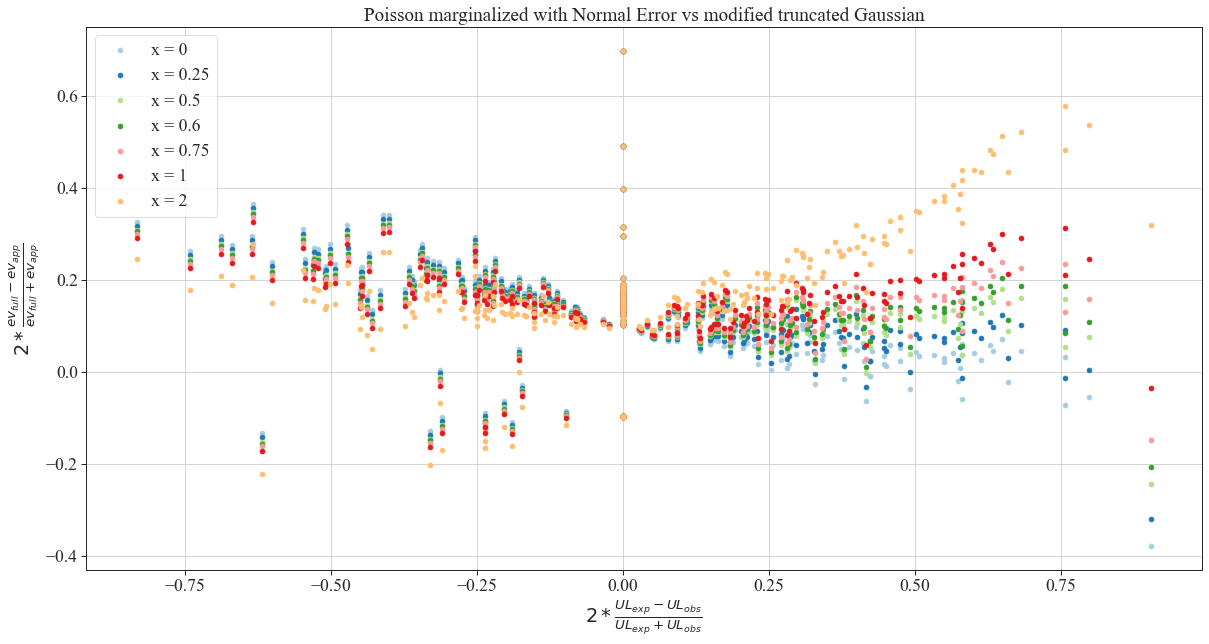

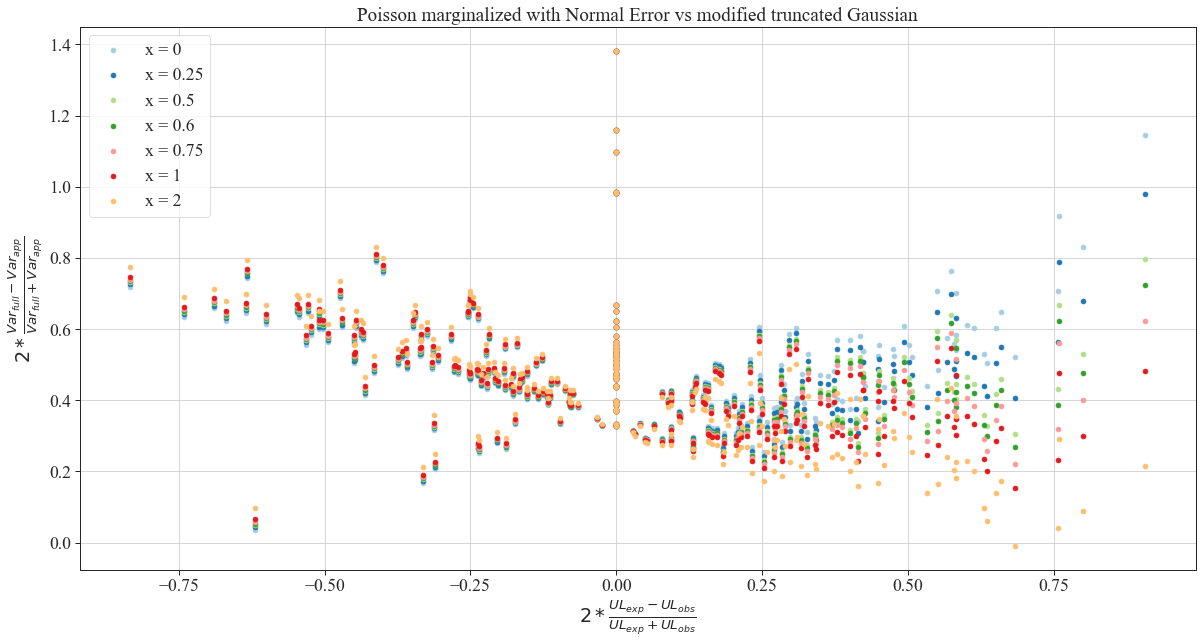

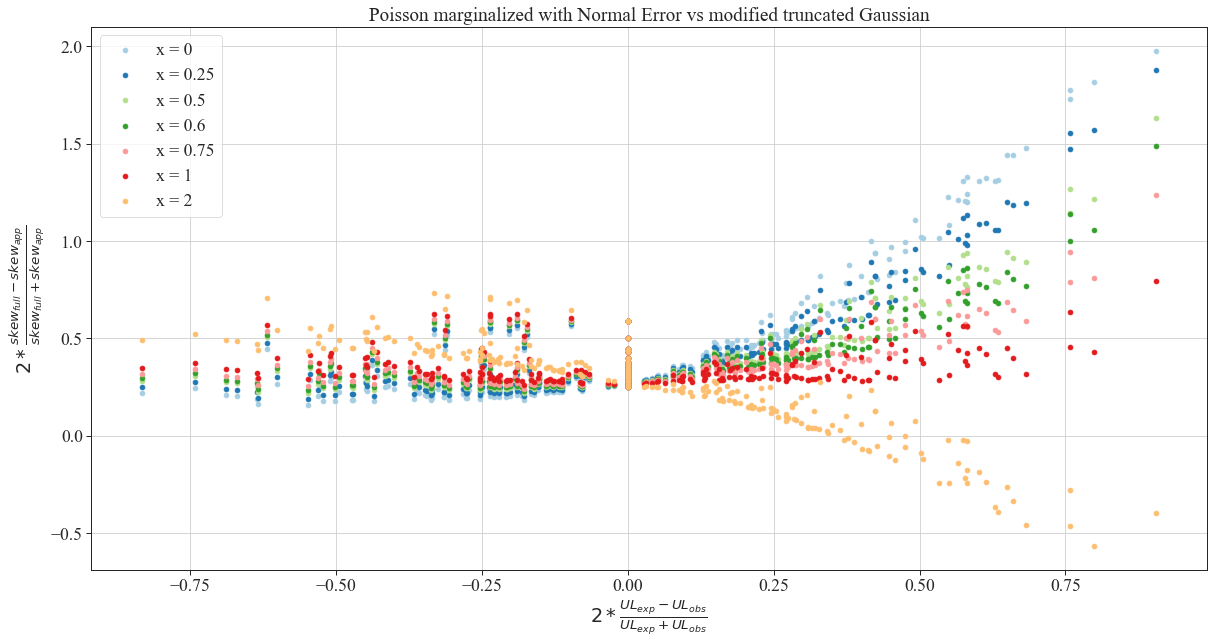

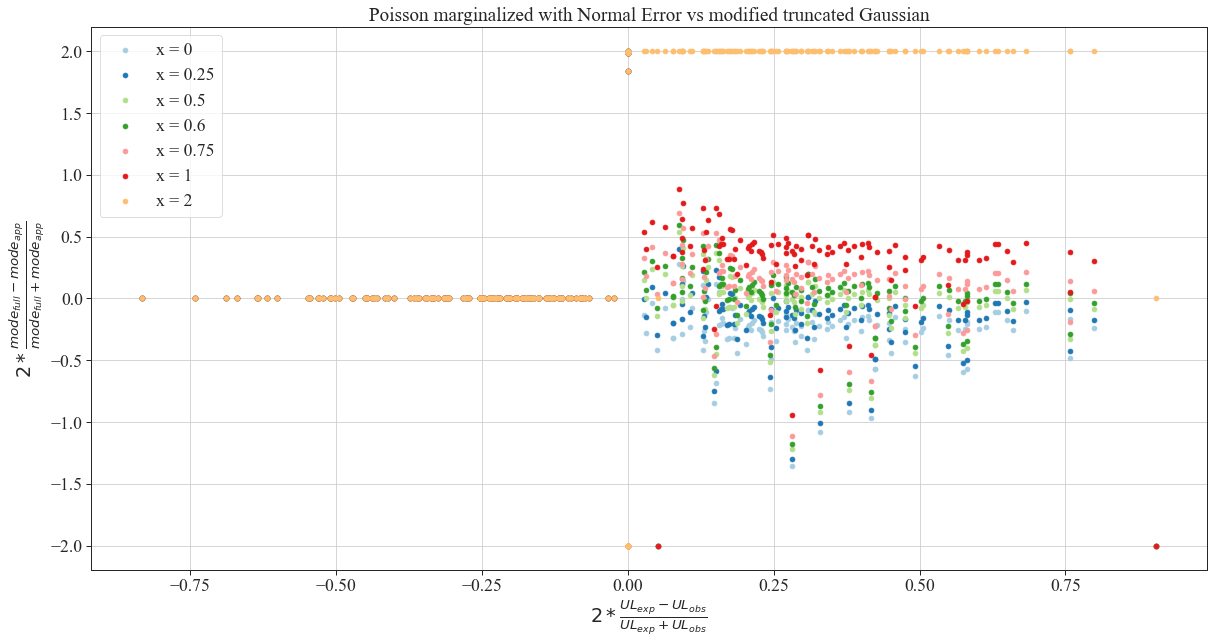

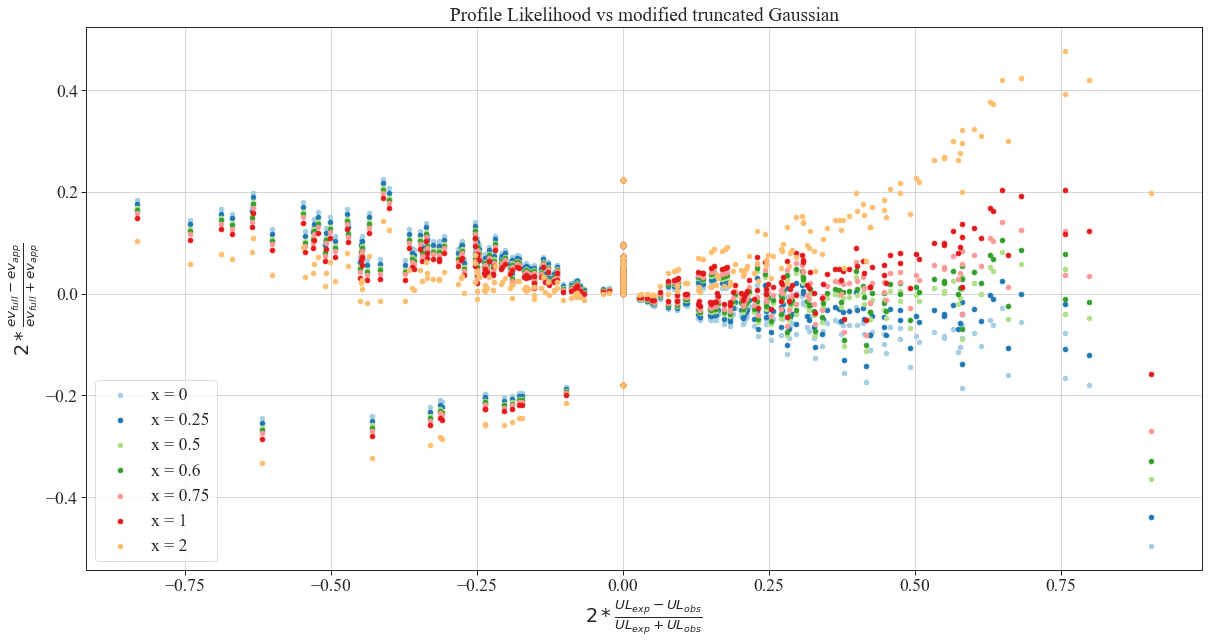

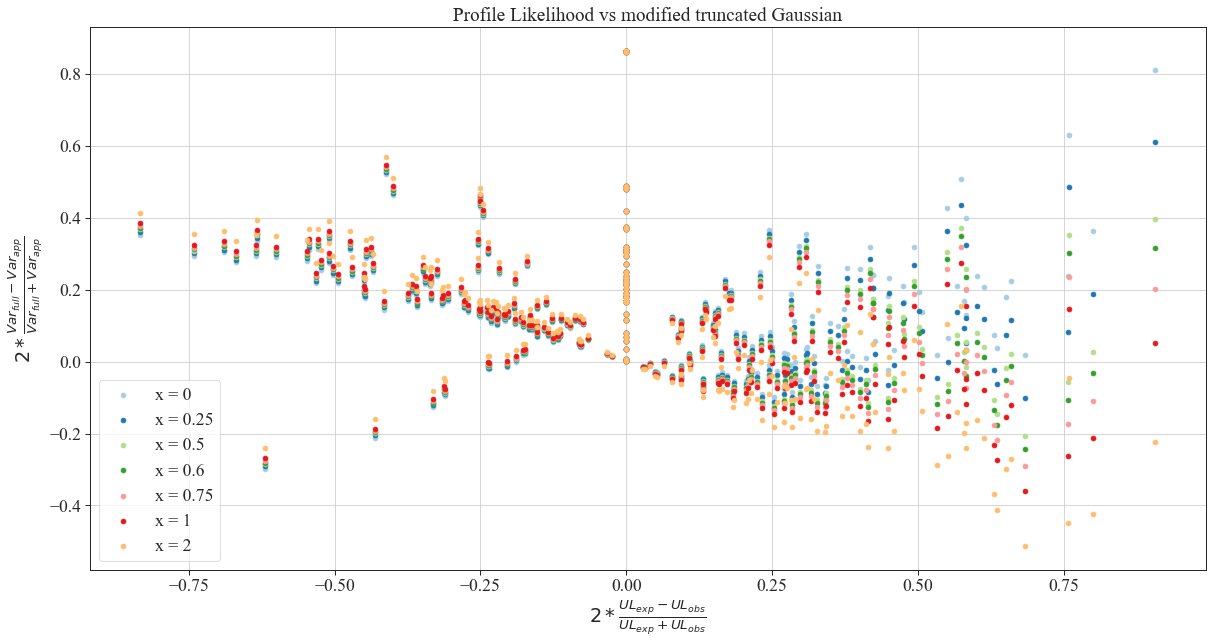

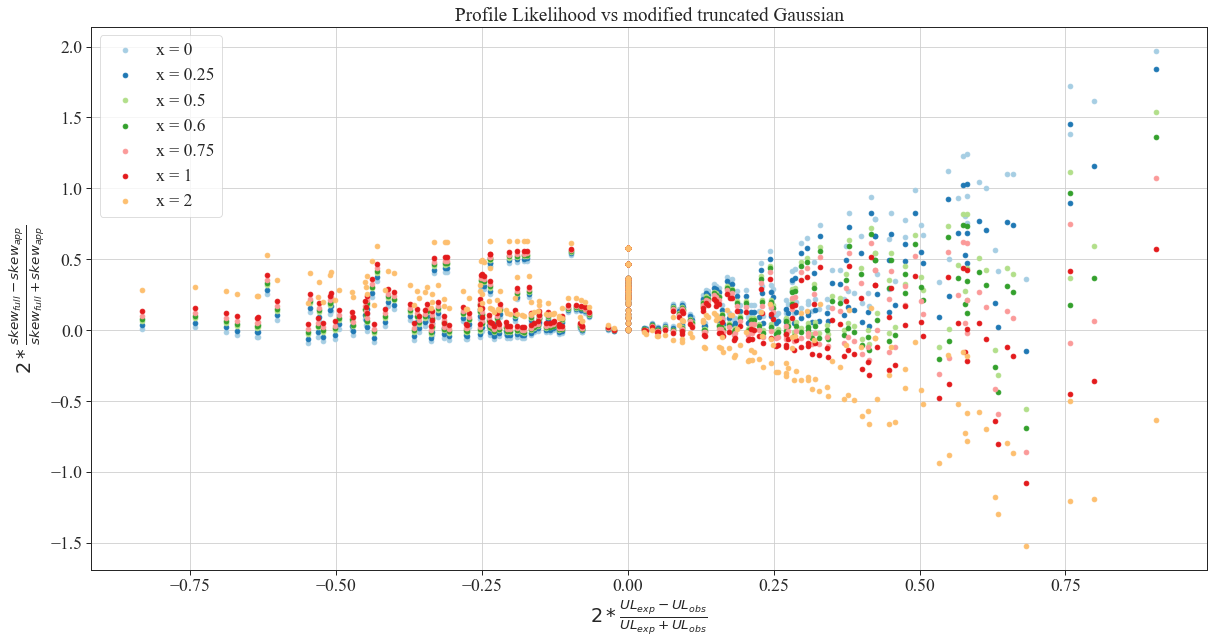

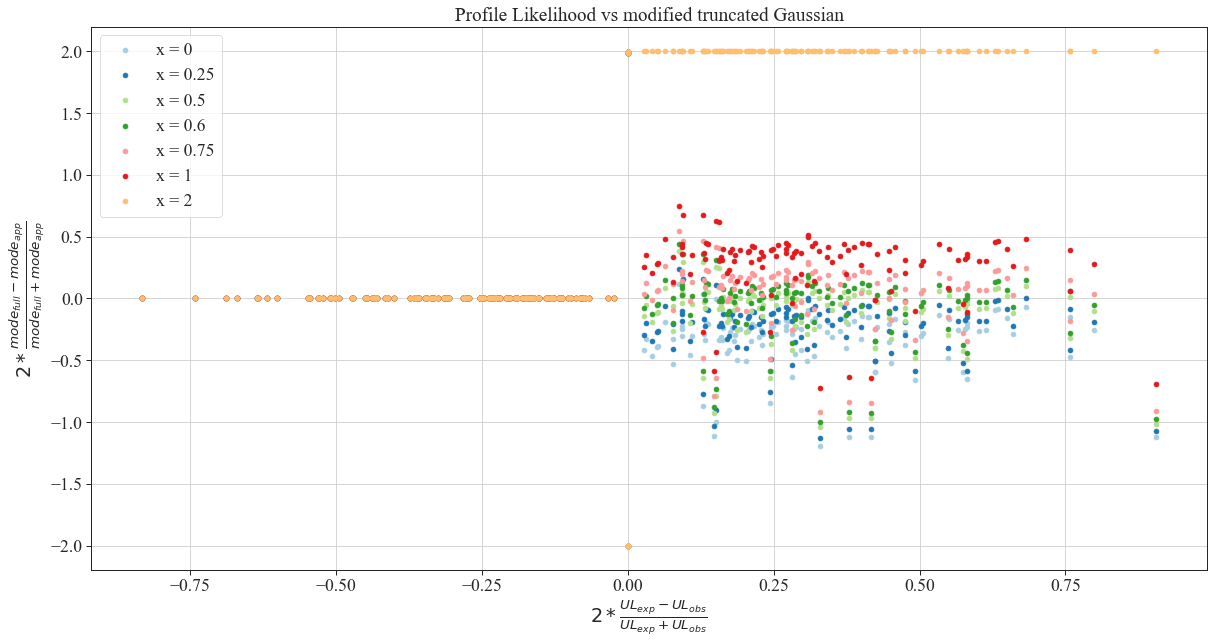

In [38]:
if not os.path.exists("scatter_mod"):
    os.mkdir("scatter_mod")
    makescatterplots()
else:
    new_plot = input('Would you like to redo the scatterplots? (y/n)\n')
    if new_plot.lower() == 'yes' or new_plot.lower() == 'y':
        shutil.rmtree("scatter_mod")
        os.mkdir("scatter_mod")
        makescatterplots()
    else:
        print("Aborting")